In [18]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn import metrics, model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [19]:
# Choose a target
target = "NR-AR"

# import the processed dataset for algorithms what require scaled variables
print('Load Pickle')
pickle_in = open(target + "_processeddata.pkl", "rb")
[param, train_smi, test_smi, train_mol_id, test_mol_id,  X_train, X_test, y_train, y_test] = pickle.load(pickle_in)
pickle_in.close()
print('Finished')

# standardization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Load Pickle
Finished


We generate a random forest classifier in the full feature space

In [20]:
# Initialize SMOTE and Random Forest
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# generate a random forest model
rf = RandomForestClassifier(n_estimators=500, random_state=100)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=500, random_state=100)

In [21]:
# Define stratified k-fold cross-validation
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'f1': metrics.make_scorer(metrics.f1_score),
    'roc_auc': 'roc_auc',
    'auc_pr': metrics.make_scorer(metrics.average_precision_score)
}

# Perform cross-validation with SMOTE and Random Forest
cv_results = model_selection.cross_validate(rf, X_resampled, y_resampled, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)

# Print the results for each metric
for metric in scoring.keys():
    print(f'{metric}: {cv_results["test_" + metric].mean():.4f} ± {cv_results["test_" + metric].std():.4f}')

f1: 0.9886 ± 0.0022
roc_auc: 0.9989 ± 0.0005
auc_pr: 0.9854 ± 0.0027


Do Hyperparameter tuning with SMOTE

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
  #  'rf__max_features': ['auto', 'sqrt'],
  #  'rf__bootstrap': [True, False]
}

# Initialize RandomizedSearchCV with SMOTE pipeline
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=50,  # Number of random combinations to try
                                   scoring='f1',  # Use F1-score as the primary metric
                                   cv=cv,        # Stratified 5-fold cross-validation
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_resampled, y_resampled)

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [23]:
best_rf = random_search.best_estimator_
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

Calculate performance metrics for the model

In [24]:
# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

       | accuracy | sensitivity | specificity | precision 
train  |   1.00   |     1.00    |    1.00     |   1.00
test   |   0.97   |     0.40    |    0.99     |   0.76

train F1-Score: 1.00
test F1-Score: 0.53


Notice the accuracy, sensitivity and f1-score are very close to those of the kNN baseline model.  

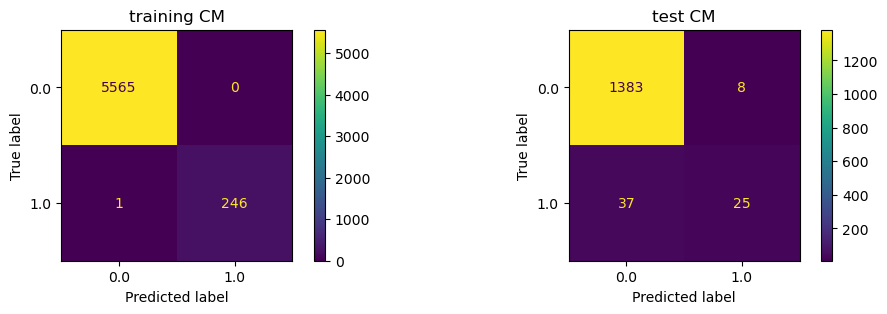

In [25]:
# plot the confusion matrices for training and test sets
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
# confusion matrix of the training set as the second subplot
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_train,y_pred_train, ax=ax3)
# set the title for the subplot
ax3.title.set_text('training CM')
# confusion matrix of the test set as the third subplot
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test, ax=ax4)
ax4.title.set_text('test CM')

train ROC-AUC: 1.00
test ROC-AUC: 0.75
train PR-AUC: 1.00
test PR-AUC: 0.47


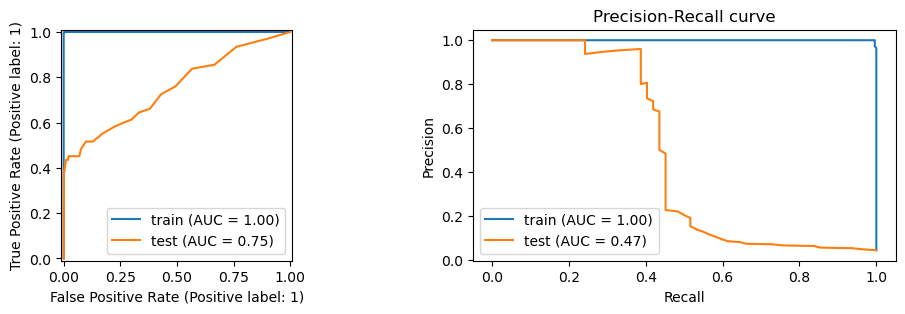

In [26]:
# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

# ROC-AUC plots as the first subplot
y_train_prob = best_rf.predict_proba(X_train)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = best_rf.predict_proba(X_test)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

In [27]:
feature_importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'feature': param, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print(feat_imp_df.head(15))

                     feature  importance
81   NumAliphaticCarbocycles    0.042785
122              fr_bicyclic    0.036826
90   NumSaturatedCarbocycles    0.036192
82         NumAliphaticRings    0.031803
92                 RingCount    0.028319
91         NumSaturatedRings    0.027787
47                  SMR_VSA4    0.023033
33                PEOE_VSA11    0.023029
87                NumHDonors    0.021834
26                     Chi4n    0.021052
131                fr_ketone    0.018199
70               EState_VSA7    0.016102
79                 NHOHCount    0.015757
5                        SPS    0.015323
125                 fr_ether    0.014199
